# Starbucks Capstone Challenge

1. [Overview](#overview)
1. [Datasets](#datasets)
1. [Import](#import)
1. [Clean Data](#clean_data)
1. [Visualization](#visualization)
1. [ML process](#ml_process)
1. [Summary](#summary)

## Overview

### Problem statement

The problem which needs to be solved is clearly defined. A strategy for solving the problem, including discussion of the expected solution, has been made.

### Metrics

Metrics used to measure performance of a model or result are clearly defined. Metrics are justified based on the characteristics of the problem.

### note
- Not all users receive the same offer, and that is the challenge to solve with this data set.

- This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

- Every offer has a validity period before the offer expires. 

- someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. 

For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. 

Or you could build a model that predicts whether or not someone will respond to an offer. 

Or, you don't need to build a machine learning model at all. 

You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

## Datasets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


## import 

In [58]:
# import necesary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import math
import json
import matplotlib.pyplot as plt
import sklearn
import datetime

In [59]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Clean Data

### portfolio

In [60]:
# ckeck the dataset overview
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
reward        10 non-null int64
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
offer_type    10 non-null object
id            10 non-null object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [61]:
# look the dataset
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [62]:
def clean_portfolio(pf=portfolio):
    '''
    IMPUT
    - portforio(df): with columns below
        channels(list), difficulty(int),duration(int),id(str),
        offer_type(str),reward(int)
    OUTPUT
    - pf(df): with columns below
        mobile(0/1),email(0/1),web(0/1),social(0/1),
        offer_type(str),difficulty(int),reward(int),duration(int),
        offer_id(str)
    DESCRIPTION
    '''

    web=[]
    email=[]
    mobile=[]
    social=[]
    channel = [[web,"web"],[email,"email"],[mobile,"mobile"],[social,"social"]]

    # transform channel column to each columns(web,email,mobile,social) with 0 or 1.
    for lt, col_name in channel:
        for x in pf["channels"]:
            if (col_name in x):
                lt.append(1)
            else:
                lt.append(0)
        pf[col_name] = lt    # append new colum to the dataframe

    # remain necessary columns
    pf = pf.loc[:, ["mobile","email","web","social","offer_type","difficulty","reward","duration","id"]]

    # arrange the appearance
    pf = pf.sort_values(['offer_type','difficulty'],ascending=[True, False]) #sort by offer_type and difficulty
    pf = pf.reset_index().drop("index",axis=1) #reset index
    pf = pf.rename(columns={'id': 'offer_id'}) #rename column to adjust to other DataFrames
    
    return pf 

In [63]:
# ckeck the clean portfolio dataframe
portfolio = clean_portfolio()
portfolio

,mobile,email,web,social,offer_type,difficulty,reward,duration,offer_id
0,1,1,0,1,bogo,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd
1,1,1,1,1,bogo,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0
2,1,1,1,0,bogo,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9
3,1,1,1,1,bogo,5,5,5,f19421c1d4aa40978ebb69ca19b0e20d
4,0,1,1,0,discount,20,5,10,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,1,1,1,1,discount,10,2,10,fafdcd668e3743c1bb461111dcafc2a4
6,1,1,1,0,discount,10,2,7,2906b810c7d4411798c6938adc9daaa5
7,1,1,1,1,discount,7,3,7,2298d6c36e964ae4a3e7e9706d1fb8c2
8,1,1,1,0,informational,0,0,4,3f207df678b143eea3cee63160fa8bed
9,1,1,0,1,informational,0,0,3,5a8bc65990b245e5a138643cd4eb9837


### proflie

In [64]:
# ckeck the dataset overview
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
gender              14825 non-null object
age                 17000 non-null int64
id                  17000 non-null object
became_member_on    17000 non-null int64
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


some data (age, id, became_member_on) contains 2175 null value

In [65]:
# check the first 5 lows
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


(array([1308., 1438., 2054., 3383., 3257., 2031.,  966.,  361.,   27.,
        2175.]),
 array([ 18.,  28.,  38.,  48.,  58.,  68.,  78.,  88.,  98., 108., 118.]),
 <a list of 10 Patch objects>)

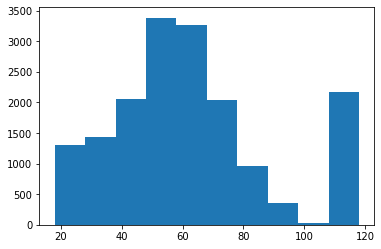

In [66]:
plt.hist(profile["age"])

age 118 seems invalid data (it's not reasonable because they are too many and elder)

In [67]:
profile[profile["age"] == 118].head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN


In [68]:
profile[profile["age"] == 118].shape

(2175, 5)

the data with age 118 doesn't contain gender and income data, and the number of data match with the number of null values above. delete those data from the dataset.

In [69]:
int(str(profile["became_member_on"][0])[:4])

2017

In [70]:
def clean_profile(profile = profile):
    '''
    IMPUT
    - profile(df): with colums of gender(str),age(int),id(str),became_member_on(str),income(int)
    OUTPUT
    - profile(df): with colums of gender(str),age(int),person_id(str),became_member_on(str),income(int)
    DESCRIPTION
    - delete lows with age 118
    - change the column name from id to person_id 
    - change the became_member_on(int) to became_member(date)
    '''
    profile = profile[profile["age"] != 118]
    profile = profile.rename(columns={'id': 'person_id'})
    
    
    # transform became_member_on(int) to became_member_year(int)
    year_list = []
    for date_int in profile["became_member_on"]:
        year = int(str(date_int)[:4])
        year_list.append(year)
    profile["became_member_year"] = year_list
    profile = profile.drop("became_member_on",axis=1)
        
    return profile

In [71]:
profile = clean_profile()

In [72]:
profile.head()

,gender,age,person_id,income,became_member_year
1,F,55,0610b486422d4921ae7d2bf64640c50b,112000.0,2017
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017
5,M,68,e2127556f4f64592b11af22de27a7932,70000.0,2018
8,M,65,389bc3fa690240e798340f5a15918d5c,53000.0,2018
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017


### transcript

In [73]:
# ckeck the dataset overview
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
person    306534 non-null object
event     306534 non-null object
value     306534 non-null object
time      306534 non-null int64
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [74]:
# check the first 5 lows
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [75]:
def clean_transcript(transcript = transcript):
    '''
    INPUT
        transcript(df): with colums of event(str),person(str),time(int),value(dict)
    OUTPUT
        tr_transaction(df): with colums below
            person_id(str),time(int),amount(float)
        tr_offer(df): with colums below
            person_id(str),time(int),offer_id(str),received(1/0),viewed(1/0),completed(1/0)
    DESCRIPTION
    - rename the column "person" to "person_id"
    - create two dataframe
        - the data which event is transaction
        - the data which event is offer(received, viewed, completed)
    '''
    
    # rename the column
    transcript = transcript.rename(columns={'person': 'person_id'})
    
    # 1. create transaction DataFrame ("event" == transaction)
    tr_transaction = transcript[transcript["event"]=="transaction"]
    
    ## clean tr_tranaction
    tr = tr_transaction
    amount = []
    for x in tr["value"]:
        if ("amount" in x):
            amount.append(x["amount"])
        else:
            amount.append(0)
    
    tr["amount"] = amount
    tr_transaction = tr.drop(["value","event"], axis=1)
    
    
    # 2. create offer DataFrame ("event" != transaction)
    tr_received = transcript[transcript["event"]=="offer received"]
    tr_viewed = transcript[transcript["event"]=="offer viewed"]
    tr_completed = transcript[transcript["event"]=="offer completed"]
    tr_offer = pd.concat([tr_received,tr_viewed,tr_completed])
    
    ## clean tr_offer
    tr = tr_offer
    offer_id = []
    for x in tr["value"]:
        if ('offer id' in x):
            offer_id.append(x['offer id'])
        elif ('offer_id' in x):
            offer_id.append(x['offer_id'])
        else:
            offer_id.append(0)

    tr["offer_id"] = offer_id
    tr = tr.drop("value", axis=1)

    ## offer events to each column
    viewed=[]
    received=[]
    completed=[]
    events = [[viewed,"viewed"],[received,"received"],[completed,"completed"]]

    for lt, col_name in events:
        for x in tr["event"]:
            if (col_name in x):
                lt.append(1)
            else:
                lt.append(0)
        tr[col_name] = lt

    tr_offer = tr.drop("event", axis=1).loc[:, ["person_id","time","offer_id","received","viewed","completed"]]
    tr_offer = tr_offer.rename(columns={'id': 'person_id'})
    
    return tr_transaction, tr_offer

In [76]:
tr_transaction, tr_offer = clean_transcript()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [77]:
tr_offer.head()

,person_id,time,offer_id,received,viewed,completed
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0
2,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,1,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,1,0,0
4,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,1,0,0


In [78]:
tr_transaction.head()

,person_id,time,amount
12654,02c083884c7d45b39cc68e1314fec56c,0,0.83
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56
12659,54890f68699049c2a04d415abc25e717,0,13.23
12670,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51
12671,fe97aa22dd3e48c8b143116a8403dd52,0,18.97


## Visualization

### profile

(array([ 611.,  558.,  536.,  551.,  662.,  800., 1082., 1256., 1432.,
        1462., 1298., 1192.,  983.,  907.,  509.,  408.,  254.,  192.,
          92.,   40.]),
 array([ 18.  ,  22.15,  26.3 ,  30.45,  34.6 ,  38.75,  42.9 ,  47.05,
         51.2 ,  55.35,  59.5 ,  63.65,  67.8 ,  71.95,  76.1 ,  80.25,
         84.4 ,  88.55,  92.7 ,  96.85, 101.  ]),
 <a list of 20 Patch objects>)

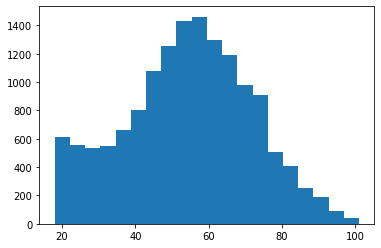

In [79]:
plt.hist(profile["age"], bins = 20)

In [80]:
profile_gender = profile.groupby("gender").count().rename(columns={'age': 'count'})["count"]
profile_gender

gender
F    6129
M    8484
O     212
Name: count, dtype: int64

In [81]:
profile.describe()

,age,income,became_member_year
count,14825.000000,14825.000000,14825.000000
mean,54.393524,65404.991568,2016.620169
std,17.383705,21598.299410,1.198245
min,18.000000,30000.000000,2013.000000
25%,42.000000,49000.000000,2016.000000
50%,55.000000,64000.000000,2017.000000
75%,66.000000,80000.000000,2017.000000
max,101.000000,120000.000000,2018.000000


(array([ 939., 1001.,  929.,  912., 1356., 1305., 1202., 1126., 1457.,
         881.,  702.,  707.,  598.,  617.,  297.,  278.,  265.,  253.]),
 array([ 30000.,  35000.,  40000.,  45000.,  50000.,  55000.,  60000.,
         65000.,  70000.,  75000.,  80000.,  85000.,  90000.,  95000.,
        100000., 105000., 110000., 115000., 120000.]),
 <a list of 18 Patch objects>)

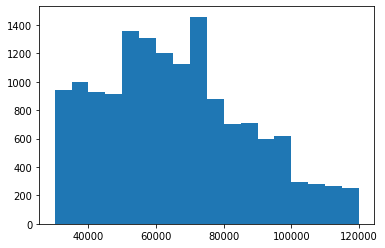

In [82]:
plt.hist(profile[profile['income'].notnull()]["income"], bins=18)

split into 3 seguments: 
low/high/mid

(array([ 274.,  662., 1597., 3024., 9268.]),
 array([2013., 2014., 2015., 2016., 2017., 2018.]),
 <a list of 5 Patch objects>)

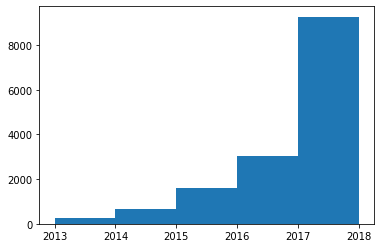

In [83]:
plt.hist(profile[profile['became_member_year'].notnull()]["became_member_year"], bins=5)

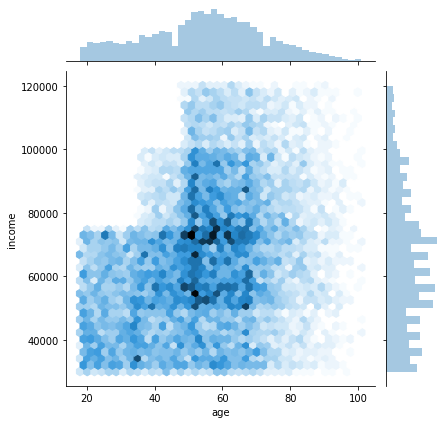

In [84]:
sns.jointplot(x="age", y="income", data=profile, kind="hex")

split into 3 seguments:
earily:2013-2014
mid   :2015-2017
late  :2017-

### transcript

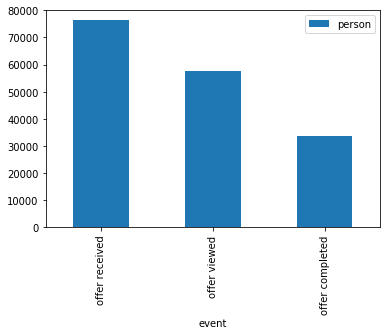

In [85]:
event_type = transcript.groupby("event").count().drop(["time", "value"], axis =1)
event_type = event_type.iloc[[1,2,0],:]
event_type.plot.bar()

### combine

In [86]:
# success rate of each offer

In [87]:
tr_offer1 = tr_offer
tr_offer1 = tr_offer1.groupby(['offer_id']).sum().drop("time",axis=1).reset_index()
tr_offer1 = pd.merge(tr_offer1,portfolio)
tr_offer1 = tr_offer1.loc[:,["offer_id","offer_type","difficulty","reward","duration","received","viewed","completed"]]


In [88]:
tr_offer1

,offer_id,offer_type,difficulty,reward,duration,received,viewed,completed
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,20,5,10,7668,2663,3420
1,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,7,3,7,7646,7337,5156
2,2906b810c7d4411798c6938adc9daaa5,discount,10,2,7,7632,4118,4017
3,3f207df678b143eea3cee63160fa8bed,informational,0,0,4,7617,4144,0
4,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,10,5,7593,7298,3331
5,5a8bc65990b245e5a138643cd4eb9837,informational,0,0,3,7618,6687,0
6,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,5,7,7677,4171,4354
7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,10,7,7658,6716,3688
8,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,5,5,7571,7264,4296
9,fafdcd668e3743c1bb461111dcafc2a4,discount,10,2,10,7597,7327,5317


In [89]:
offer_type = tr_offer1.groupby("offer_type").sum()
offer_type = offer_type.loc[:,["received","viewed","completed"]]

In [90]:
offer_type.head()

,received,viewed,completed
offer_type,,,
bogo,30499,25449,15669
discount,30543,21445,17910
informational,15235,10831,0


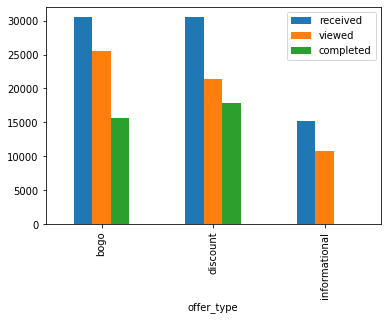

In [91]:
offer_type.plot.bar()

In [92]:
offer_type["rate_viewed"] = offer_type["viewed"]/offer_type["received"]
offer_type["rate_completed"] = offer_type["completed"]/offer_type["received"]
offer_type

,received,viewed,completed,rate_viewed,rate_completed
offer_type,,,,,
bogo,30499,25449,15669,0.834421,0.513755
discount,30543,21445,17910,0.702125,0.586386
informational,15235,10831,0,0.710929,0.000000


## ML Process

When Starbucks sends customers some discount promotions(BOGO and DISCOUNT), the reactions are classified into below:

- view     -> complete (success)  
    customers check the promotion and react on it. It's succes of the promotion offer.
- view     -> NOT complete (fail)  
    customers check the promotion but they don't use it. 
- Not view -> complete (no_contribute)  
    customers don't check the promotion but they use the promotion offer. the offer doesn't affect to the customer however the promotion costs.  
- Not view -> NOT complete (no_interest)  
    customers neither check and use the promotion offer.
      

From the perspective of business cost performance, Starbuckswant to increase success and decrease no_contribute.
I'd like to create a classification ML program to predict how customers react to a certain offer. 

### data preparation

- cerate X,Y dataset  
combine 3 dataframes(df_result, pf, profile)and drop unnecesary columns 

- X  
age, become_member_on, gender, income, channel(mail...etc), 
offer_type, difficulty, reward, duration

- Y  
success, fail, no_cont, no_interest

In [93]:
# tr_offer preparation

In [94]:
def offer_result(tr_offer = tr_offer):
    '''
    INPUT
        tr_offer(df): with colums below
            person_id(str),time(int),offer_id(str),received(1/0),viewed(1/0),completed(1/0)
    OUTPUT
        df_result(df): with colums below
            person_id(str),offer_id(str),time(int),received(1/0),viewed(1/0),completed(1/0),
            success(1/0),fail(1/0),no_cont(1/0),no_int(1/0)
    DESCRIPTION
    - create four columns: success, fail, no_cont, and no_int
    - sort by time
    '''
    df_prep = tr_offer.groupby(["person_id","offer_id"]).sum()

    df_prep["success"] = 0
    df_prep["fail"] = 0
    df_prep["no_cont"] = 0
    df_prep["no_int"] = 0

    df_success = df_prep[(df_prep["viewed"]>0) & (df_prep["completed"]>0)]
    df_success["success"] = 1 

    df_fail = df_prep[(df_prep["viewed"]>0) & (df_prep["completed"]==0)]
    df_fail["fail"] = 1 

    df_no_cont = df_prep[(df_prep["viewed"]==0) & (df_prep["completed"]>0)]
    df_no_cont["no_cont"] = 1 


    df_no_int = df_prep[(df_prep["viewed"]==0) & (df_prep["completed"]==0)]
    df_no_int["no_int"] = 1 

    df_result = pd.concat([df_success, df_fail, df_no_cont, df_no_int])
    df_result = df_result.sort_values("time")
    df_result = df_result.reset_index()
    
    return df_result

In [97]:
df_result = offer_result(tr_offer)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-

In [98]:
df_result.head()

,person_id,offer_id,time,received,viewed,completed,success,fail,no_cont,no_int
0,2efa56bdd66f404299852e789396daf7,2906b810c7d4411798c6938adc9daaa5,0,1,0,0,0,0,0,1
1,5807ddcd40ce4cd588ae5f58e7ed76b7,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,0,0,0,0,1
2,79501c86985d4ea08eded43b1cbc3a8c,2298d6c36e964ae4a3e7e9706d1fb8c2,0,1,1,0,0,1,0,0
3,3874c70761894a869f17aadaaf97f014,2298d6c36e964ae4a3e7e9706d1fb8c2,0,1,1,0,0,1,0,0
4,2b2de48725e74246ad75278d604c9908,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,0,0,0,0,1


In [38]:
tr_offer_prep = offer_result(tr_offer = tr_offer)
tr_offer_prep.head()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

,person_id,offer_id,time,received,viewed,completed,success,fail,no_cont,no_int
0,2efa56bdd66f404299852e789396daf7,2906b810c7d4411798c6938adc9daaa5,0,1,0,0,0,0,0,1
1,5807ddcd40ce4cd588ae5f58e7ed76b7,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,0,0,0,0,1
2,79501c86985d4ea08eded43b1cbc3a8c,2298d6c36e964ae4a3e7e9706d1fb8c2,0,1,1,0,0,1,0,0
3,3874c70761894a869f17aadaaf97f014,2298d6c36e964ae4a3e7e9706d1fb8c2,0,1,1,0,0,1,0,0
4,2b2de48725e74246ad75278d604c9908,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,0,0,0,0,1


In [39]:
def pf_prep(pf_prep=portfolio):
    '''
    INPUT
        portfolio(df): with colums below
            mobile(0/1),email(0/1),web(0/1),social(0/1),offer_type(str),
            difficulty(int),reward(int),duration(int), offer_id(str)
    OUTPUT
        pf_prep(df): with colums below
            mobile(0/1),email(0/1),web(0/1),social(0/1),
            difficulty(int),reward(int),duration(int), offer_id(str),
            bogo(0/1),discount(0/1),info(0/1)
            
    DESCRIPTION
    - replace offer_type column to each column(bogo,discount,info)
    ''' 
    bogo=[]
    discount=[]
    info=[]

    promo = [[bogo,"bogo"],[discount,"discount"],[info,"info"]]

    for lt, col_name in promo:
        for x in pf_prep["offer_type"]:
            if (col_name in x):
                lt.append(1)
            else:
                lt.append(0)
        pf_prep[col_name] = lt

    pf_prep = pf_prep.drop("offer_type", axis=1)
    return pf_prep

In [40]:
pf_prep = pf_prep()

In [41]:
pf_prep.head()

,mobile,email,web,social,difficulty,reward,duration,offer_id,bogo,discount,info
0,1,1,0,1,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,1,0,0
1,1,1,1,1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,0,0
2,1,1,1,0,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0
3,1,1,1,1,5,5,5,f19421c1d4aa40978ebb69ca19b0e20d,1,0,0
4,0,1,1,0,20,5,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0


In [42]:
def profile_prep(pf_profile=profile):
    '''
    INPUT
        profile(df): with colums below
            gender(str),age(int),person_id(str),became_member_on(str),income(int)
    OUTPUT
        pf_profile(df): with colums below
            age(int),person_id(str),income(int),became_member_year(int),M(0/1),F(0/1),O(0/1)            
    DESCRIPTION
    - replace gender column to each column(M,F,O)
    - transform became_member_on(str) to became_member_year(int)
    ''' 
    M=[]
    F=[]
    O=[]

    gender = [[M,"M"],[F,"F"],[O,"O"]]

    for lt, col_name in gender:
        for x in pf_profile["gender"]:
            if (col_name in x):
                lt.append(1)
            else:
                lt.append(0)
        pf_profile[col_name] = lt

    pf_profile = pf_profile.drop("gender", axis=1)
    return pf_profile

In [43]:
profile_prep = profile_prep()
profile_prep.head()

,age,person_id,income,became_member_year,M,F,O
1,55,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,0,1,0
3,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,0,1,0
5,68,e2127556f4f64592b11af22de27a7932,70000.0,2018,1,0,0
8,65,389bc3fa690240e798340f5a15918d5c,53000.0,2018,1,0,0
12,58,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017,1,0,0


In [44]:
def df_prep(tr_offer_prep, pf_prep, profile_prep):
    '''
    INPUT
        tr_offer_prep(df): with colums below
            person_id(str),offer_id(str),time(int),received(1/0),viewed(1/0),completed(1/0),
            success(1/0),fail(1/0),no_cont(1/0),no_int(1/0)
        pf_prep(df): with colums below
            mobile(0/1),email(0/1),web(0/1),social(0/1),
            difficulty(int),reward(int),duration(int), offer_id(str),
            bogo(0/1),discount(0/1),info(0/1)
        pf_profile(df): with colums below
            age(int),person_id(str),income(int),became_member_year(int),M(0/1),F(0/1),O(0/1)
    OUTPUT
        df_prep(df): with colums below
            time(int),success(0/1),fail(0/1),no_cont(0/1),no_int(0/1),
            mobile(0/1),email(0/1),web(0/1),social(0/1),
            difficulty(int),reward(int),duration(int),bogo(0/1),discount(0/1),info(0/1),
            age(int),income(int),became_member_year(int),M(0/1),F(0/1),O(0/1)
    DESCRIPTION
    - replace gender column to each column(M,F,O)
    - transform became_member_on(str) to became_member_year(int)
    ''' 
    df_prep = pd.merge(tr_offer_prep, pf_prep ,on="offer_id")
    df_prep = pd.merge(df_prep, profile_prep ,on="person_id")

    df_prep = df_prep.drop(["received","viewed","completed"],axis=1)
    df_prep = df_prep.drop(["person_id","offer_id"],axis=1)
    
    return df_prep

In [45]:
df_prep = df_prep(tr_offer_prep, pf_prep, profile_prep)

In [46]:
df_prep.head()

,time,success,fail,no_cont,no_int,mobile,email,web,social,difficulty,...,duration,bogo,discount,info,age,income,became_member_year,M,F,O
0,0,0,0,0,1,1,1,1,0,10,...,7,0,1,0,20,39000.0,2017,1,0,0
1,1386,1,0,0,0,1,1,1,1,10,...,10,0,1,0,20,39000.0,2017,1,0,0
2,2046,1,0,0,0,1,1,1,1,5,...,5,1,0,0,20,39000.0,2017,1,0,0
3,0,0,0,0,1,1,1,1,0,10,...,7,0,1,0,56,50000.0,2017,1,0,0
4,912,0,0,0,1,0,1,1,0,20,...,10,0,1,0,56,50000.0,2017,1,0,0


In [47]:
df_prep.shape

(55222, 21)

In [100]:
df_prep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55222 entries, 0 to 55221
Data columns (total 21 columns):
time                  55222 non-null int64
success               55222 non-null int64
fail                  55222 non-null int64
no_cont               55222 non-null int64
no_int                55222 non-null int64
mobile                55222 non-null int64
email                 55222 non-null int64
web                   55222 non-null int64
social                55222 non-null int64
difficulty            55222 non-null int64
reward                55222 non-null int64
duration              55222 non-null int64
bogo                  55222 non-null int64
discount              55222 non-null int64
info                  55222 non-null int64
age                   55222 non-null int64
income                55222 non-null float64
became_member_year    55222 non-null int64
M                     55222 non-null int64
F                     55222 non-null int64
O                     55222 n

In [48]:
## create X_train, Y_train, X_test, Y_test

In [49]:
def create_test_train(df=df_prep, num_test = 5000):
    '''
    INPUT
        df_prep(df): with colums below
        num_test(int): the number of test data. the rest of data become train data.
   　OUTPUT
        X_train(df),X_test(df): colums below
            mobile(0/1),email(0/1),web(0/1),social(0/1),
            difficulty(int),reward(int),duration(int),bogo(0/1),discount(0/1),info(0/1),
            age(int),income(int),became_member_year(int),M(0/1),F(0/1),O(0/1)
        Y_train(df),Y_test(df):columns below
            success(0/1),fail(0/1),no_cont(0/1),no_int(0/1)
    DESCRIPTION
    - devide into X_train,Y_train,X_test,Y_test dataset
    - test dataset includes 'nun_test' numbers of rows, and the rest of the data is in train.
    ''' 
    df1 = df_prep.sort_values("time")
    df1 = df1.reset_index().drop(["index","time"], axis=1)
    
    X = df1.drop(["success","fail","no_cont","no_int"],axis=1)
    Y = df1.loc[:,["success","fail","no_cont","no_int"]]
    
    
    num_train = df.shape[0] -num_test
    
    X_train = X.head(num_train)
    X_test = X.tail(num_test)
    
    Y_train = Y.head(num_train)
    Y_test = Y.tail(num_test)
    
    return X_train, Y_train, X_test, Y_test

In [50]:
X_train, Y_train, X_test, Y_test = create_test_train()

In [51]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((50222, 16), (5000, 16), (50222, 4), (5000, 4))

In [52]:
X_train.head()

,mobile,email,web,social,difficulty,reward,duration,bogo,discount,info,age,income,became_member_year,M,F,O
0,1,1,1,0,10,2,7,0,1,0,20,39000.0,2017,1,0,0
1,1,1,0,1,10,10,7,1,0,0,54,53000.0,2018,0,1,0
2,0,1,1,0,20,5,10,0,1,0,63,40000.0,2014,1,0,0
3,1,1,0,1,10,10,7,1,0,0,53,108000.0,2018,0,1,0
4,0,1,1,0,20,5,10,0,1,0,67,73000.0,2018,1,0,0


In [53]:
Y_train.head()

,success,fail,no_cont,no_int
0,0,0,0,1
1,0,1,0,0
2,0,0,0,1
3,0,0,0,1
4,0,0,0,1


###  Random Forest

In [53]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [54]:
clf = RandomForestClassifier(max_depth=30, n_estimators=30, random_state=42)
clf.fit(X_train, Y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(Y_test, y_pred)
print('Accuracy: {}'.format(accuracy))

Accuracy: 0.6082


In [55]:
#Decide on some random forest parameter candidates
parameters = {
    'n_estimators' :[3,5,10,30,50],#Number of decision trees to create
    'random_state' :[7,42],
    'max_depth' :[3,5,8,10,30],#Decision tree depth
    'min_samples_leaf': [2,5,10,20,50],#Minimum number of samples of the node that has finished branching
    'min_samples_split': [2,5,10,20,50]#Number of samples required when the decision tree branches
}

#Use grid search
from sklearn.model_selection import GridSearchCV
clf = GridSearchCV(estimator=RandomForestClassifier(), param_grid=parameters, cv=2, iid=False)

#Create learning model
clf.fit(X_train, Y_train)

GridSearchCV(cv=2, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [56]:
y_pred = clf.predict(X_test)
accuracy = accuracy_score(Y_test, y_pred)
print('Accuracy: {}'.format(accuracy))

Accuracy: 0.6246


In [57]:
clf.best_params_

{'max_depth': 30,
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 3,
 'random_state': 42}

In [58]:
y_pred

array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       ...,
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0]])

In [ ]:
# test
# mobile	email	web	social	difficulty	reward	duration	bogo	discount	info	age	income	became_member_year	M	F	O

In [62]:
test1 = [[1,1,1,1,10,10,5,1,0,0,40,500000,2019,1,0,0],
         [1,1,1,1,10,10,5,1,0,0,40,500000,2019,1,0,0]]

In [64]:
y_pred = clf.predict(test1)
y_pred

array([[0, 1, 0, 0],
       [0, 1, 0, 0]])

In [ ]:
# create correlation heatmap

In [169]:
corr = df_prep.corr()

In [183]:
corr = corr.loc[["mobile","web","social","difficulty","reward","duration","bogo","discount","info","age","income","became_member_year","M","F","O"],
                ["success","fail","no_cont","no_int"]]
corr = corr.sort_values("success", ascending=False)

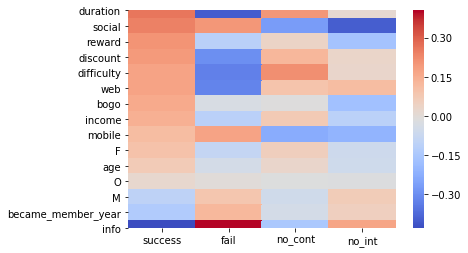

In [184]:
sns.heatmap(corr, cmap='coolwarm')

In [22]:
channel= "mobile"

In [23]:
mobile = 0
email = 0
web = 0
social = 0

In [24]:
mobile,email,web,social

(0, 0, 0, 0)

In [25]:
m = 0
f = 0
o = 0
if gender == "m":
    m = 1
if gender == "f":
    f = 1
if gender == "o":
    o = 1

    
    if type_offer == "discount":
    discount = 1

In [26]:
mobile,email,web,social

(1, 0, 0, 0)

In [ ]:
mobile,email,web,social = 0
# mobile,email,web,social
#channels
    web=[]
    email=[]
    mobile=[]
    social=[]
    channel = [[web,"web"],[email,"email"],[mobile,"mobile"],[social,"social"]]
    for lt, col_name in channel:
        for x in pf["channels"]:
            if (col_name in x):
                lt.append(1)
            else:
                lt.append(0)
        pf[col_name] = lt    # append new colum to the dataframe